In [736]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
sns.set(style="whitegrid")
from pySankey import sankey
#pd.set_option('display.float_format', '{:.2f}'.format)

In [737]:
df = pd.read_csv('dataTP1.csv')

In [738]:
df.columns

Index(['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval',
       'Bureaucratic_Code', 'Account_Created_Date', 'Source ',
       'Billing_Country', 'Account_Name', 'Opportunity_Name', 'Opportunity_ID',
       'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner',
       'Account_Type', 'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Last_Activity',
       'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By',
       'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP',
       'ASP_(converted)_Currency', 'ASP_(converted)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'Actual_Delivery_Date', 'TRF',
       'Total_Amount_Currenc

In [739]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16499 entries, 0 to 16498
Data columns (total 54 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  16499 non-null  int64  
 1   Region                              16499 non-null  object 
 2   Territory                           16499 non-null  object 
 3   Pricing, Delivery_Terms_Quote_Appr  16499 non-null  int64  
 4   Pricing, Delivery_Terms_Approved    16499 non-null  int64  
 5   Bureaucratic_Code_0_Approval        16499 non-null  int64  
 6   Bureaucratic_Code_0_Approved        16499 non-null  int64  
 7   Submitted_for_Approval              16499 non-null  int64  
 8   Bureaucratic_Code                   16499 non-null  object 
 9   Account_Created_Date                16499 non-null  object 
 10  Source                              16499 non-null  object 
 11  Billing_Country                     16499

###### Ojo ID es el id del cada registro (osea de cada fila que es único por fila), que no es igual a Opportunity_ID (ID de la oportunidad), ya que puedo tener varios registros (filas) para una misma oportunidad.

In [740]:
df['Submitted_for_Approval'].value_counts()

0    16499
Name: Submitted_for_Approval, dtype: int64

In [741]:
df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Hemisferio,Estación
0,27761,Europa,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,NaT,10,EUR,5272800.00,EUR,5272800.00,Closed Lost,Prod_Category_A_None,None,NaN
1,27760,Europa,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,NaT,0,EUR,48230.00,EUR,48230.00,Closed Won,Prod_Category_A_None,None,NaN
2,27446,América,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,NaT,0,USD,83865.60,USD,83865.60,Closed Won,Prod_Category_A_None,Hemisferio Norte,Otoño
3,16808,América,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,NaT,14,USD,7421881.50,USD,7421881.50,Closed Lost,Prod_Category_A_None,Hemisferio Norte,Otoño
4,16805,América,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,NaT,25,USD,13357192.50,USD,13357192.50,Closed Lost,Prod_Category_A_None,Hemisferio Norte,Otoño


In [742]:
df['Opportunity_Created_Date']=pd.to_datetime(df['Opportunity_Created_Date'])

## 1. Stage

* #### Stage es nuestra variable target, variable que nos indica el estado de la oportunidad, o sea si la oportunidad resultó en éxito o no (closed won o closed lost respectivamente).

In [743]:
# Veamos sus valores únicos y cantidades
df['Stage'].value_counts()

Closed Won       9300
Closed Lost      7135
Proposal           35
Negotiation        18
Qualification      11
Name: Stage, dtype: int64

* Se observa en dicha variable que, además de los estados que indican si una oportunidad resultó exitosa o no (**estados finales**), tenemos otros 3 estados (Proposal, Negotiation y Qualification) que corresponden a **estados intermedios** que tienen las oportunidades dentro del pipeline que desarrolla la empresa.

* Como con esta variable se estará luego tratando de predecir la “Probabilidad de éxito” para cada oportunidad, o sea ¿Cuál es la probabilidad de que la oportunidad se convierta en un caso Closed Won? .Que decisión debemos tomar con dichos estados? Dichos estados al no tener una resolución, debemos asignarle arbitrariamente algún estado final? Debemos filtrar estos casos?

> Luego de analizar esos registros con estos estados intermedios y verificar que corresponen a oportunidades que no tuvieron aún en desenlase exitoso o no y tenindo en cuenta que corresponden a unos pocos casos, tomamos la decisión de filtrar estos registros y quedarnos solamente con los que tienen un estado final definido.

In [744]:
df = df.loc[(df['Stage']!='Proposal') & (df['Stage']!='Negotiation') & (df['Stage']!='Qualification'),:]

#### En nuestro set de datos: ¿Cuántas oportunidades resultaron exitosas y cuantas no lo fueron?

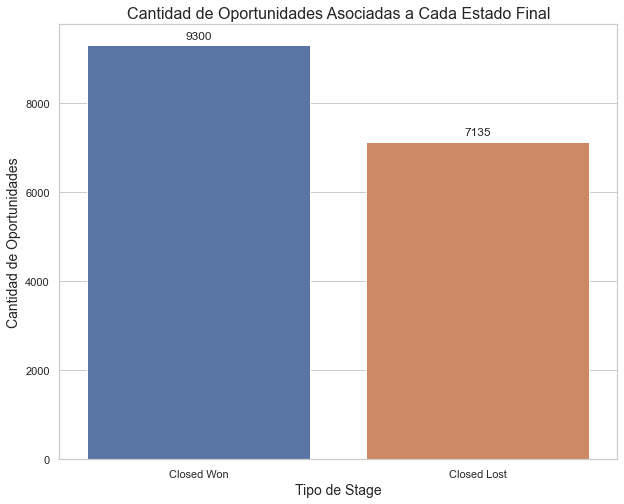

In [745]:
target = df['Stage'].value_counts()
plt.subplots(figsize=(10,8))
grafico_top7=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico_top7.patches:
    grafico_top7.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico_top7.set_title("Cantidad de Oportunidades Asociadas a Cada Estado Final",fontsize=16)
grafico_top7.set_ylabel("Cantidad de Oportunidades",fontsize=14)
grafico_top7.set_xlabel("Tipo de Stage",fontsize=14);

In [746]:
df['Stage'].value_counts(normalize=True)

Closed Won    0.57
Closed Lost   0.43
Name: Stage, dtype: float64

* Se observa que en nuestro set de datos predominan las Oportunidades que resultaron Exitosas, con 9300 casos (57%) frente a las No Exitosas con 7135 casos (43%)

## 2. Región:

#### ¿Cuántas rigiones distintas tenemos en nuestro set de datos y como se distribuyen las cantidasdes de Oportunidades en las mismas?

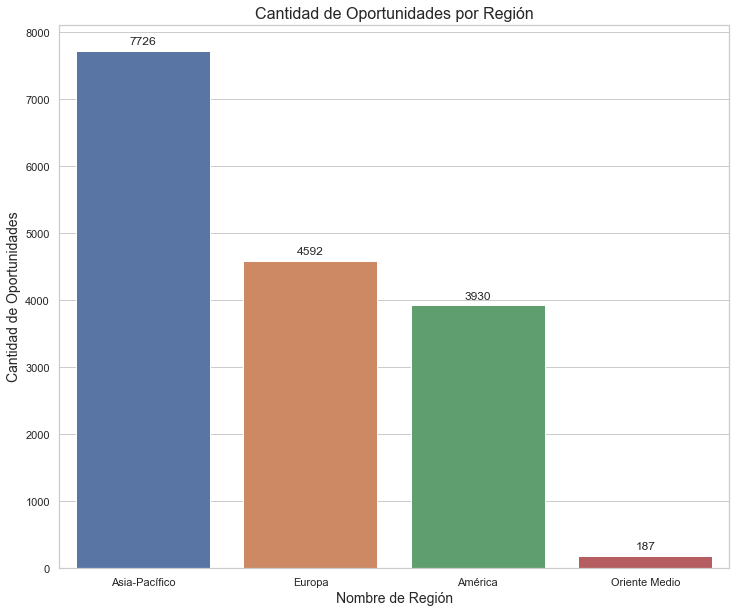

In [747]:
target = df['Region'].value_counts()
plt.subplots(figsize=(12,10))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Cantidad de Oportunidades por Región",fontsize=16)
grafico.set_ylabel("Cantidad de Oportunidades",fontsize=14)
grafico.set_xlabel("Nombre de Región",fontsize=14);

* La Región Asia-Pacífico es la predominante con 7726 oportunidades, es importante destacar que el valor alcanzado por esta Región, mucho tiene que ver con lo realizado en el Preprocesamiento de los datos. A ésta Región le asignamos a Japón como territorio perteneciente. Este dato no es menor ya que Japón representa el 63% del total de oportunidades de la Región Asia-Pacífico y un 30% del Total de oportunidades globales. Las Regiones que le siguen son Europa y América en cantidad de oportunidades con valores no tan dispares, 4592 y 3930 respectivamente. Finalmente Oriente Medio es la Región que presenta menos oportunidades para la empresa con solamnete 187.

In [748]:
df.loc[df['Region']=='Asia-Pacífico',:]['Territory'].value_counts(normalize=True).head()

Japan         0.63
Australia     0.11
India         0.10
Singapore     0.06
China (PRC)   0.03
Name: Territory, dtype: float64

In [749]:
df['Territory'].value_counts(normalize=True).head()

Japan        0.30
Germany      0.10
NW America   0.09
Australia    0.05
India        0.05
Name: Territory, dtype: float64

#### ¿Cómo se distribuyen las oportunidades exitosas y no exitosas según las distintas Regiones?

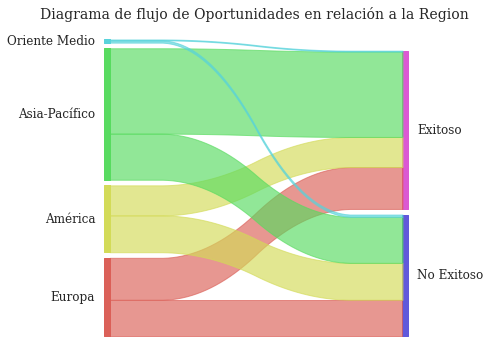

In [750]:
df['Oportunidad']= '' 
df.loc[df['Stage']== 'Closed Won','Oportunidad']= 'Exitoso'
df.loc[df['Stage']== 'Closed Lost','Oportunidad']= 'No Exitoso'
sankey.sankey(df['Region'],df['Oportunidad'],aspect=20, fontsize=12)
plt.title('Diagrama de flujo de Oportunidades en relación a la Region ',fontsize=14);

* Asia-Pacífico, que como vimos es la Región que más oportunidades presenta y también es la que mayor casos Exitosos tiene como era de esperar, pero notamos que su flujo hacia los casos Exitosos es mayor que a los No Exitosos, mientras que las demás Regiones a simple vista presentan una distribución bastante similar hacia casos Exitosos y No Exitosos.

#### Si quiero cuantificar esas distribuciones de Oportunidades en Exitosas o No Exitosas según cada Región. ¿Cuáles son esas cantidades?

In [751]:
df['veces'] = 1
mi_map=pd.crosstab(df['Region'], df['Stage'],values=df.veces,aggfunc=np.sum)

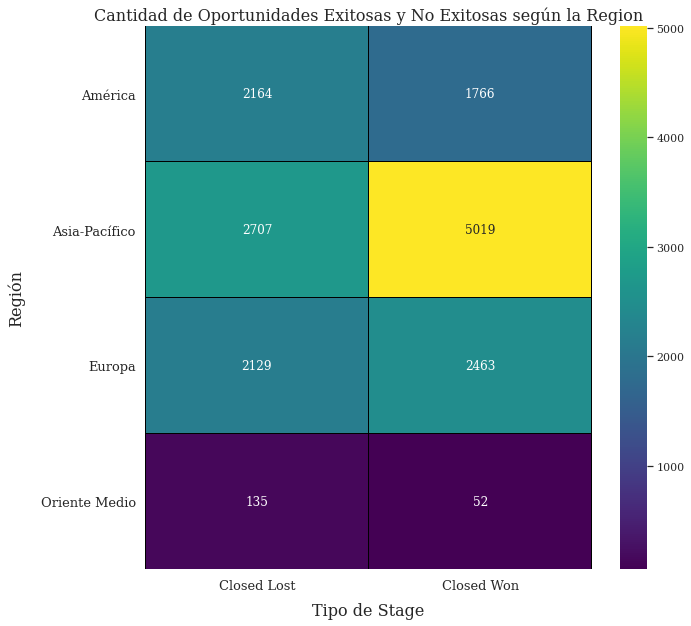

In [752]:
fig, ax = plt.subplots(figsize=(10,10))
g = sns.heatmap(mi_map, cmap="viridis", ax=ax, linewidths=0.005, linecolor='black',annot=True,fmt='g')
g.set_title("Cantidad de Oportunidades Exitosas y No Exitosas según la Region", fontsize=16)
g.set_xlabel("Tipo de Stage", fontsize=16, labelpad=10)
g.set_ylabel("Región", fontsize=16, labelpad=16, rotation=90)
g.set_xticklabels(g.get_xticklabels(), fontsize=13)
g.set_yticklabels(g.get_yticklabels(), fontsize=13, rotation=0)
g.title.set_position([0.5, 1.05])
plt.show()

* Al cuantificar los valores de casos Exitosos y No Exitosos asociados a cada Región podemos ver varias cosas interesantes. Para Asia-Pacífico, no solo las cantidades exitosas son mayores a las no exitosas sinó que representan una alta cantidad del total de oportunidades de dicha Región,más precisamente un 65%. Europa también presenta mayor cantidad de oportunidades exitosas en relación su total de oportunidades (2463 casos exitosos frente a 2129 no exitosos) un 54% aproximadamente. Para las dos Regiones restantes (América y Oriente Medio) los casos no exitosos son los que predominan en el total de oportunidades de dichas regiones.

#### ¿Cómo es la evolución anual de la cantidad de Oportunidades según la Región?

In [753]:
df['Año_Oportunidad']=df['Opportunity_Created_Date'].dt.year

In [754]:
df['Opportunity_Created_Date'].nlargest(3)

15653   2018-12-29
15654   2018-12-29
15655   2018-12-29
Name: Opportunity_Created_Date, dtype: datetime64[ns]

In [755]:
df['Opportunity_Created_Date'].nsmallest(3)

15656   2013-11-05
15657   2014-03-21
15658   2014-03-28
Name: Opportunity_Created_Date, dtype: datetime64[ns]

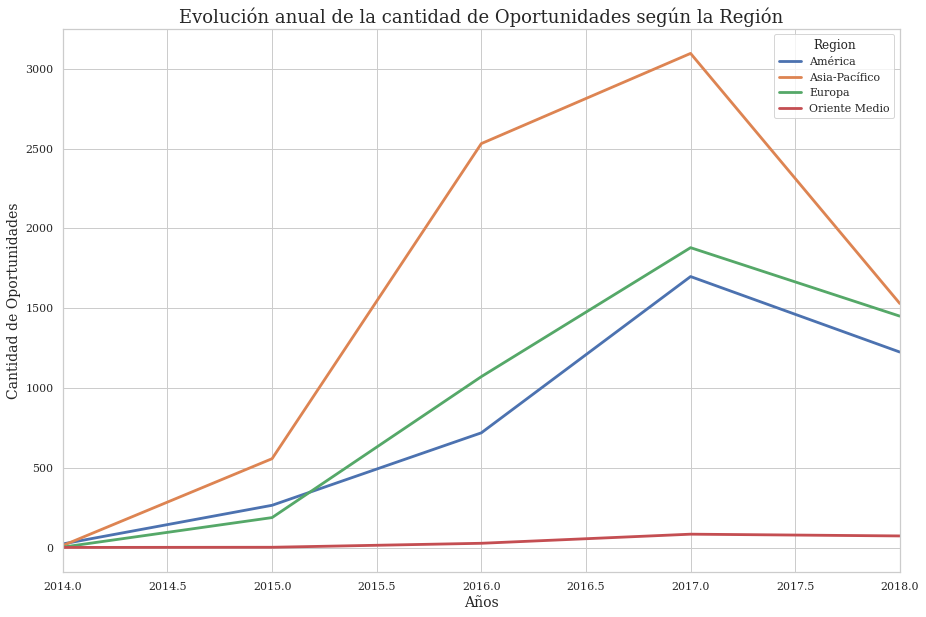

In [756]:
grafico=pd.crosstab(df['Año_Oportunidad'],df['Region']).plot(figsize=(15,10),linewidth=2.8);
grafico.set_title("Evolución anual de la cantidad de Oportunidades según la Región",fontsize=18)
plt.xlim(2014,2018)
grafico.set_xlabel("Años",fontsize=14)
grafico.set_ylabel("Cantidad de Oportunidades",fontsize=14);

* Oriente Medio en general presenta un comportamiento prácticamente constante con muy bajas cantidades de oportunidades, las cuales tuvieron un tenue incremento entre 2016 y 2017.

* Las regiones América, Europa y Asia-Pacífico de 2014 a 2015 notamos que presentan un incremento en cantidad de oportunidades. Asia-Pacífico presenta un más marcado incremento (mayor pendiente) que las dos primeras. América y Europa en este período tienen una pendiete similar, con la primera Región levemente por encima de la segunda. 

* Asia-Pacífico continúa con el crecimiento en cantidad de oportunidades de 2015 a 2017 siendo más notorio su incremento en el príodo 2015-2016 que en 2016-2017. Luego de 2017 a 2018 ocurre una brusca caída, terminando con cantidades cercanas a Europa.

* América y Europa también continúan con el crecimiento en cantidad de oportunidades de 2015 a 2017 pero ésta última supera a la primera antes de la mitad del 2015 con una pendiente positiva constante hasta el 2017. América por su lado de 2015 a 2016 tuvo una menor pendiente positiva pero de 2016 a 2017 muestra una mayor recuperación. Luego, de 2017 al 2018 ambas Regiones presentan pendiente negativas denotando caídas en las oportunidades, aunque no tan bruscas como Asia-Pacífico.

## 3. Hemisferio

#### ¿Cómo se distribuyen las oportunidades exitosas y no exitosas según los distintas Hemisferios?

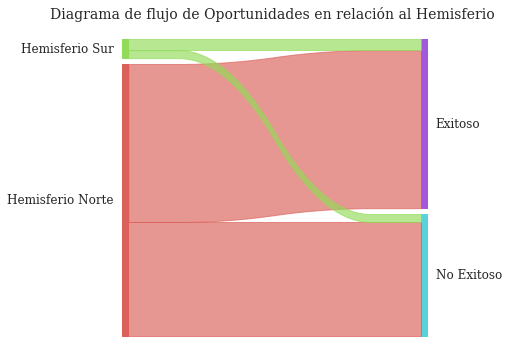

In [757]:
# Filtro primeramente los valores correspondiente a los 2 Hemisferios con los que cuento información(filtro casos nulos)
hemisferios = df.loc[df['Hemisferio']!='None',:]
sankey.sankey(hemisferios['Hemisferio'],df['Oportunidad'],aspect=20, fontsize=12)
plt.title('Diagrama de flujo de Oportunidades en relación al Hemisferio ',fontsize=14);

* (Analizar)

#### Si quiero cuantificar esas distribuciones de Oportunidades en Exitosas o No Exitosas según cada Hemisferio. ¿Cuáles son esas cantidades?

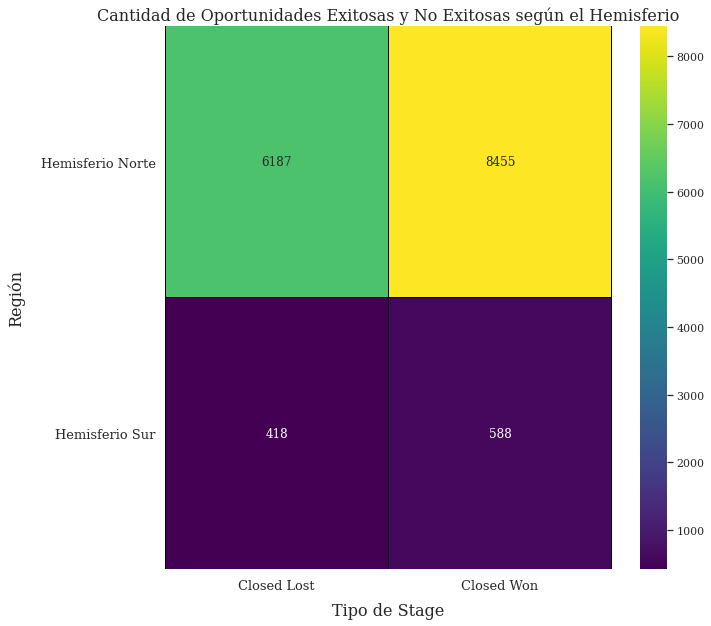

In [758]:
df['veces'] = 1
mi_map=pd.crosstab(hemisferios['Hemisferio'], hemisferios['Stage'],values=df.veces,aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(10,10))
g = sns.heatmap(mi_map, cmap="viridis", ax=ax, linewidths=0.005, linecolor='black',annot=True,fmt='g')
g.set_title("Cantidad de Oportunidades Exitosas y No Exitosas según el Hemisferio", fontsize=16)
g.set_xlabel("Tipo de Stage", fontsize=16, labelpad=10)
g.set_ylabel("Región", fontsize=16, labelpad=16, rotation=90)
g.set_xticklabels(g.get_xticklabels(), fontsize=13)
g.set_yticklabels(g.get_yticklabels(), fontsize=13, rotation=0)
g.title.set_position([0.5, 1.05])
plt.show()

* (Analizar)

## 4. Territorios

#### ¿Cuáles son los 7 Territorios más populares para cada Región?

In [759]:
df_territorio=df[['Territory','Stage','Region']].copy()
df_territorio['veces'] = 1
df_territorio = df_territorio.loc[df_territorio['Territory']!='None',:]
america = df_territorio.loc[df_territorio['Region']=='América',['Territory']]
europa = df.loc[df['Region']=='Europa',['Territory']]
oriente_medio = df.loc[df['Region']=='Oriente Medio',['Territory']]
asia_pacifico = df.loc[df['Region']=='Asia-Pacífico',['Territory']]

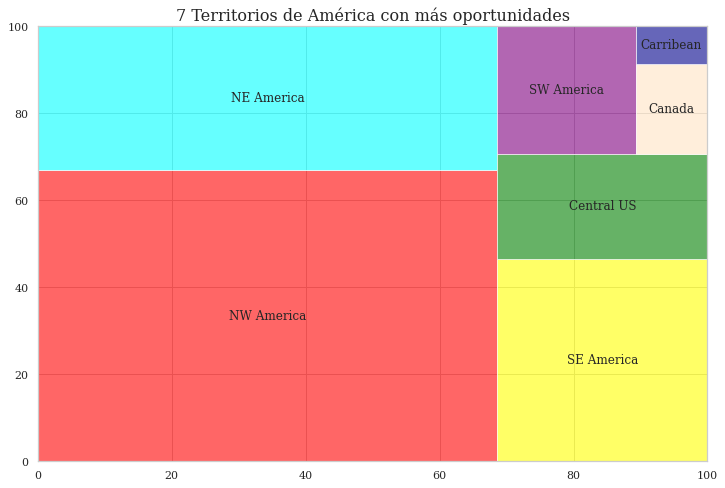

In [760]:
territorios = america['Territory'].value_counts()
data = territorios.head(7)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
visu = squarify.plot(data, label=data.index, alpha=.6,color=['red','cyan','yellow','green','purple','bisque','darkblue'],)
visu.set_title('7 Territorios de América con más oportunidades',fontsize=16);

* (Analizar)

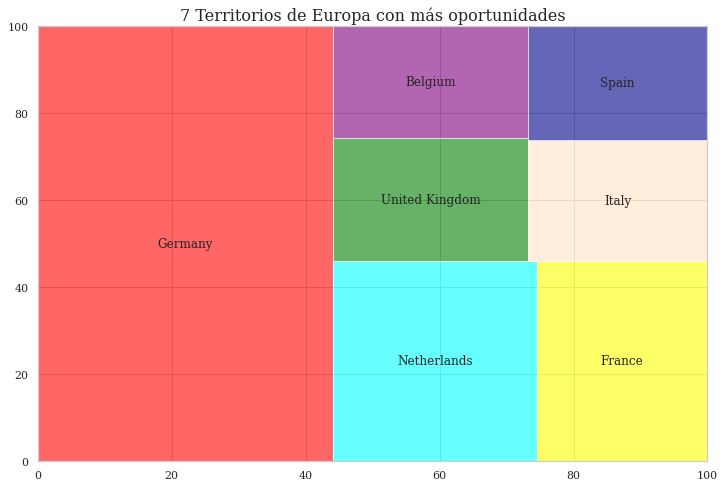

In [761]:
territorios = europa['Territory'].value_counts()
data = territorios.head(7)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
visu = squarify.plot(data, label=data.index, alpha=.6,color=['red','cyan','yellow','green','purple','bisque','darkblue'],)
visu.set_title('7 Territorios de Europa con más oportunidades',fontsize=16);

* (Analizar)

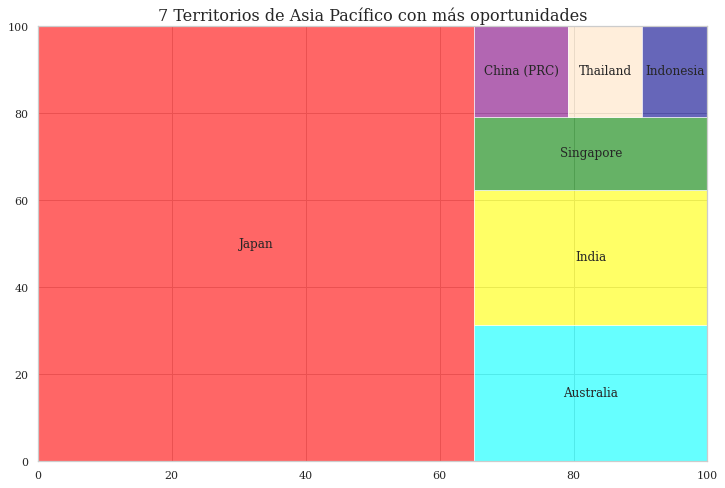

In [762]:
territorios = asia_pacifico['Territory'].value_counts()
data = territorios.head(7)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
visu = squarify.plot(data, label=data.index, alpha=.6,color=['red','cyan','yellow','green','purple','bisque','darkblue'],)
visu.set_title('7 Territorios de Asia Pacífico con más oportunidades',fontsize=16);

* (Analizar)

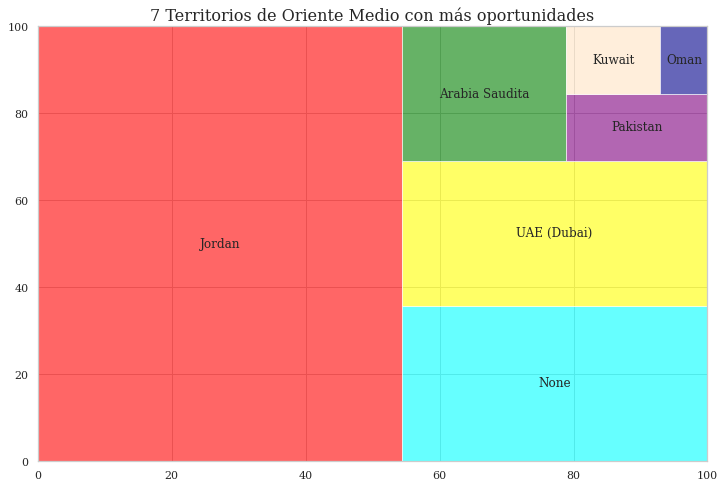

In [763]:
territorios = oriente_medio['Territory'].value_counts()
data = territorios.head(7)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
visu = squarify.plot(data, label=data.index, alpha=.6,color=['red','cyan','yellow','green','purple','bisque','darkblue'],)
visu.set_title('7 Territorios de Oriente Medio con más oportunidades',fontsize=16);

* (Analizar)

#### Independientemente de la Región. ¿Cuál es el Top 7 Territorios más populares y sus correspondientes cantidades de Oportunidades?

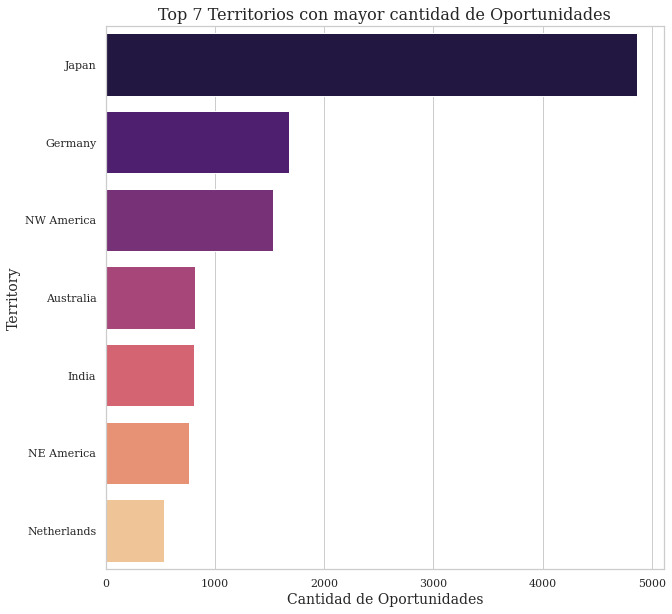

In [764]:
target = df_territorio['Territory'].value_counts().nlargest(7)
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=target.values,y=target.index,palette="magma")
grafico_top_key.set_title("Top 7 Territorios con mayor cantidad de Oportunidades",fontsize=16)
grafico_top_key.set_xlabel("Cantidad de Oportunidades",fontsize=14)
grafico_top_key.set_ylabel("Territory",fontsize=14);

* (Analizar)

#### Para los 7 Territorios con mayor cantidad de Oportunidades. ¿Cuantas de ellas son Exitosas y No Exitosas?

In [765]:
 mis_territorios = pd.pivot_table(df_territorio, values='veces', index=['Territory'],columns=['Stage'], aggfunc=np.sum, fill_value=0).reset_index()

In [766]:
target = df_territorio['Territory'].value_counts().nlargest(7)
target= target.reset_index()
target.rename(columns={'index':'Territory','Territory':'Cantidad'},inplace=True)
target

,Territory,Cantidad
0,Japan,4867
1,Germany,1678
2,NW America,1535
3,Australia,816
4,India,807
5,NE America,759
6,Netherlands,532


In [767]:
top7_territorios = pd.merge(target,mis_territorios,on='Territory')
top7_territorios.set_index('Territory',inplace=True)
top7_territorios.drop('Cantidad',axis='columns', inplace=True)
top7_territorios

,Closed Lost,Closed Won
Territory,,
Japan,1546,3321
Germany,659,1019
NW America,587,948
Australia,306,510
India,433,374
NE America,501,258
Netherlands,275,257


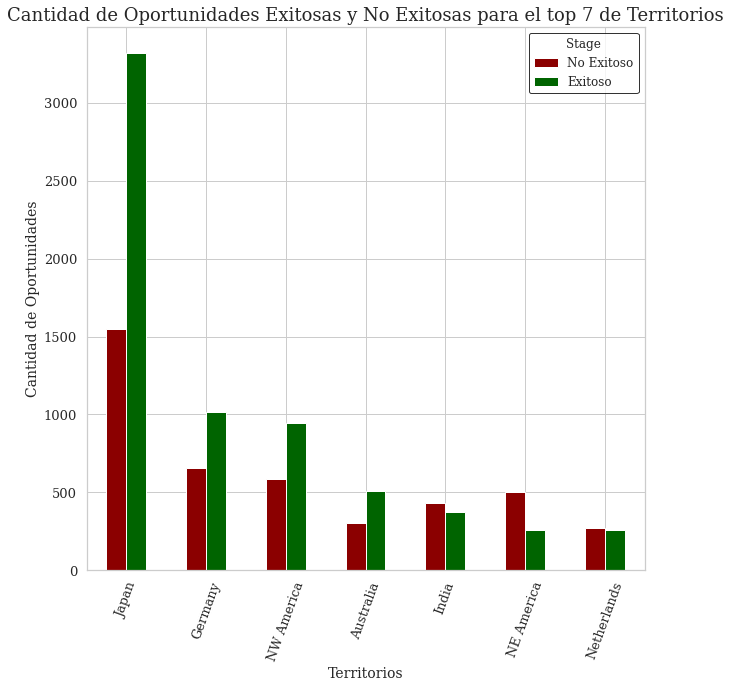

In [768]:
grafico=top7_territorios.plot(kind='bar',color=['darkred','darkgreen'],fontsize=13,figsize=(10,10),rot=70)
grafico.set_title("Cantidad de Oportunidades Exitosas y No Exitosas para el top 7 de Territorios",fontsize=18)
grafico.set_xlabel("Territorios",fontsize=14)
grafico.set_ylabel("Cantidad de Oportunidades",fontsize=14)
leyenda=plt.legend(['No Exitoso','Exitoso'],fontsize=12,title='Stage',frameon=True,facecolor='white',edgecolor='black')
leyenda.get_frame().set_linewidth(1.0)

* Es este gráfico se aprecia que, dentro del Tpo 7, solo los cuatro primeros Territorios con mayor cantidad de oportunidades presentan una mayor cantidad de casos Exitosos que no Exitosos. Destacandose Japón con una cantidad de casos Exitosos de más del doble que no Exitosos.

* Si prestamos atención un poco más al gráfico nos damos cuenta de que, si quisiéramos listar por ejemplo los tres países (en cantidad de Oportunidades) más exitosos, estos serían: Japan, Germany y NW América. Igualmente si quisiéramos listar Los tres países menos Exitosos (en cantidad de Oportunidades) nuevamente éstos serían: Japan, Germany y NW América. Esto pasa porque estamos analizando cantidades absolutas, con lo cual, para poder sacar mejores conclusiones sobre dichos Territorios sería más conveniente realizar un análisis proporcional (relativo) que contemple por ejemplo la cantidad de casos Exitosos sobre el total de casos para cada Territorio y luego sí listar esos 7 Territorios con mejor Ratio.

In [769]:
territorio_oprtunidades = pd.pivot_table(df_territorio, values='veces', index=['Territory'],columns=['Stage'], aggfunc=np.sum, fill_value=0).reset_index()
territorio_oprtunidades=territorio_oprtunidades.fillna(0)
territorio_oprtunidades['Total_Oportunidades'] = territorio_oprtunidades['Closed Lost']+ territorio_oprtunidades['Closed Won']
territorio_oprtunidades['Ratio_Oportunidades_exitosas'] = territorio_oprtunidades['Closed Won']/territorio_oprtunidades['Total_Oportunidades']
territorio_oprtunidades.head()

Stage,Territory,Closed Lost,Closed Won,Total_Oportunidades,Ratio_Oportunidades_exitosas
0,Albania,2,0,2,0.00
1,Arabia Saudita,7,7,14,0.50
2,Armenia,2,0,2,0.00
3,Australia,306,510,816,0.62
4,Austria,21,123,144,0.85


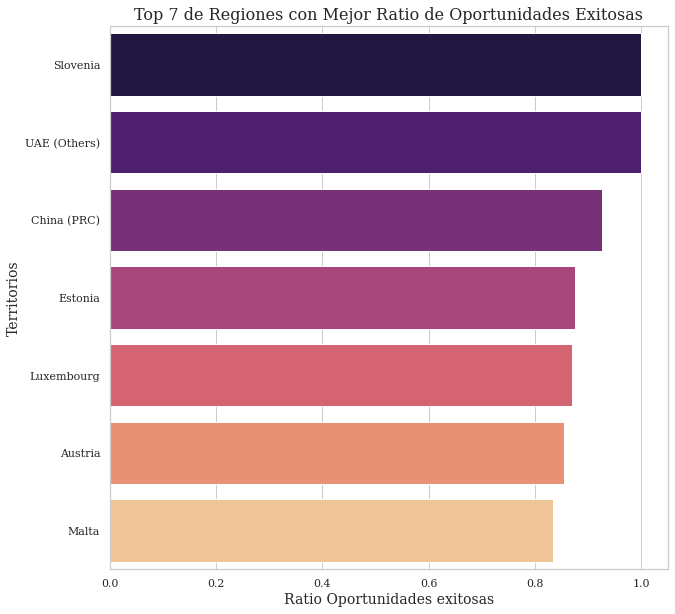

In [770]:
target = territorio_oprtunidades.nlargest(7,'Ratio_Oportunidades_exitosas')
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=target.Ratio_Oportunidades_exitosas,y=target.Territory,palette="magma")
grafico_top_key.set_title("Top 7 de Regiones con Mejor Ratio de Oportunidades Exitosas",fontsize=16)
grafico_top_key.set_xlabel("Ratio Oportunidades exitosas",fontsize=14)
grafico_top_key.set_ylabel("Territorios",fontsize=14);

* Además para que este análisis no caiga en el problema de la ecuación más paligrosa del mundo, debemos tomar ciertas restricciones, como por ejemplo que en ese Top 7 de mejores Ratios tengamos Territorios con una cantidad de Oportunidades mayor al 1,5% del Total de Oportunidades que presenta la empresa.

In [771]:
territorio_oprtunidades.Total_Oportunidades.sum()*0.015

234.72

* Ahora  filtramos los casos bajo las restricciones pedidas

In [772]:
territorio_oprtunidades=territorio_oprtunidades.loc[territorio_oprtunidades['Total_Oportunidades']>235]

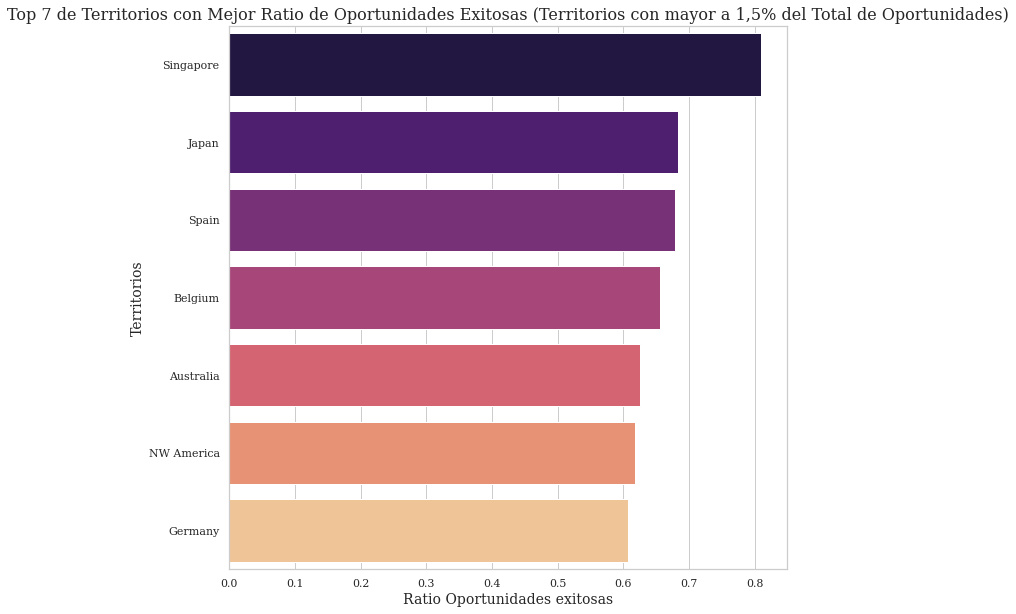

In [773]:
target = territorio_oprtunidades.nlargest(7,'Ratio_Oportunidades_exitosas')
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=target.Ratio_Oportunidades_exitosas,y=target.Territory,palette="magma")
grafico_top_key.set_title("Top 7 de Territorios con Mejor Ratio de Oportunidades Exitosas (Territorios con mayor a 1,5% del Total de Oportunidades)",fontsize=16)
grafico_top_key.set_xlabel("Ratio Oportunidades exitosas",fontsize=14)
grafico_top_key.set_ylabel("Territorios",fontsize=14);

* (Analizar)

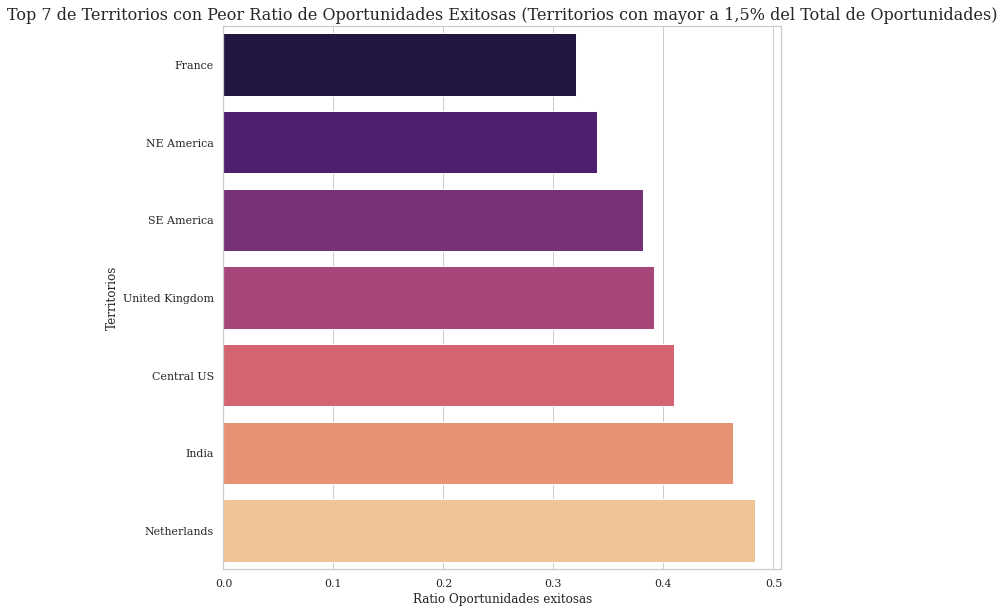

In [774]:
target = territorio_oprtunidades.nsmallest(7,'Ratio_Oportunidades_exitosas')
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=target.Ratio_Oportunidades_exitosas,y=target.Territory,palette="magma")
grafico_top_key.set_title("Top 7 de Territorios con Peor Ratio de Oportunidades Exitosas (Territorios con mayor a 1,5% del Total de Oportunidades)",fontsize=16)
grafico_top_key.set_xlabel("Ratio Oportunidades exitosas",fontsize=12)
grafico_top_key.set_ylabel("Territorios",fontsize=12);

* (Analizar)

#### Los 7 Territorios con mejor Ratio, como fue su evolución anual?

* Los 7 Territorios con mejor Ratio y su evolución en cantidad de Oportunidades

In [775]:
target = territorio_oprtunidades.nlargest(7,'Ratio_Oportunidades_exitosas')
#target= target.reset_index()
#target.rename(columns={'index':'Territory','Territory':'Cantidad'},inplace=True)
target

Stage,Territory,Closed Lost,Closed Won,Total_Oportunidades,Ratio_Oportunidades_exitosas
55,Singapore,84,355,439,0.81
31,Japan,1546,3321,4867,0.68
61,Spain,86,181,267,0.68
6,Belgium,98,187,285,0.66
3,Australia,306,510,816,0.62
43,NW America,587,948,1535,0.62
24,Germany,659,1019,1678,0.61


In [776]:
territorio_year = df[['Territory','Año_Oportunidad','Stage']]

In [777]:
top7_territorios=pd.merge(target,territorio_year,on='Territory',how='inner')
top7_territorios['veces']=1

In [778]:
pd.pivot_table(top7_territorios, values='veces', index=['Año_Oportunidad']\
               ,columns=['Territory'], aggfunc=np.sum, fill_value=0)

Territory,Australia,Belgium,Germany,Japan,NW America,Singapore,Spain
Año_Oportunidad,,,,,,,
2014,0,0,1,0,16,0,0
2015,8,1,39,489,132,2,6
2016,153,37,270,1846,245,109,65
2017,488,146,709,1763,641,167,132
2018,167,101,659,769,501,161,64


In [779]:
top7_territorios.groupby(['Año_Oportunidad','Territory'], as_index=False)['Ratio_Oportunidades_exitosas'].mean()

,Año_Oportunidad,Territory,Ratio_Oportunidades_exitosas
0,2014,Germany,0.61
1,2014,NW America,0.62
2,2015,Australia,0.62
3,2015,Belgium,0.66
4,2015,Germany,0.61
5,2015,Japan,0.68
6,2015,NW America,0.62
7,2015,Singapore,0.81
8,2015,Spain,0.68
9,2016,Australia,0.62


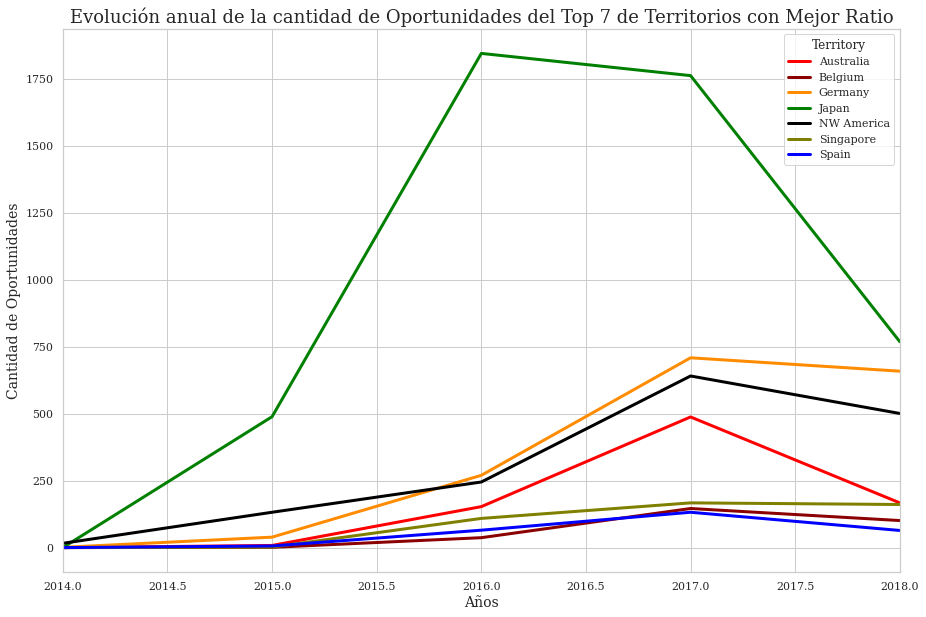

In [780]:
grafico=pd.pivot_table(top7_territorios, values='veces', index=['Año_Oportunidad']\
               ,columns=['Territory'], aggfunc=np.sum, fill_value=0).plot(figsize=(15,10),\
                color=['red','darkred','darkorange','green','black','olive','blue'],linewidth=3);
grafico.set_title("Evolución anual de la cantidad de Oportunidades del Top 7 de Territorios con Mejor Ratio",fontsize=18)
plt.xlim(2014,2018)
grafico.set_xlabel("Años",fontsize=14)
grafico.set_ylabel("Cantidad de Oportunidades",fontsize=14);

* (Analizar)

* Los 7 Territorios con mejor Ratio y la evolución temporal de su ratio.

In [781]:
top7_territorios_year=pd.pivot_table(top7_territorios, values='veces', index=['Año_Oportunidad','Territory']\
               ,columns=['Stage'], aggfunc=np.sum, fill_value=0)

In [782]:
top7_territorios_year['Total_Oportunidades']=top7_territorios_year['Closed Lost'] + top7_territorios_year['Closed Won']
top7_territorios_year['Ratio_Oportunidades_exitosas'] = top7_territorios_year['Closed Won']/top7_territorios_year['Total_Oportunidades']
top7_territorios_year

Stage                       Closed Lost  Closed Won  Total_Oportunidades  \
Año_Oportunidad Territory                                                  
2014            Germany               0           1                    1   
                NW America            5          11                   16   
2015            Australia             7           1                    8   
                Belgium               1           0                    1   
                Germany              19          20                   39   
                Japan               353         136                  489   
                NW America           83          49                  132   
                Singapore             2           0                    2   
                Spain                 5           1                    6   
2016            Australia            31         122                  153   
                Belgium              14          23                   37   
                Germany             123         147                  270   
                Japan               898         948                 1846   
                NW America          120         125                  245   
                Singapore            35          74                  109   
                Spain                24          41                   65   
2017            Australia           183         305                  488   
                Belgium              46         100                  146   
                Germany             230         479                  709   
                Japan               198        1565                 1763   
                NW America          250         391                  641   
                Singapore            35         132                  167   
                Spain                30         102                  132   
2018            Australia            85          82                  167   
                Belgium              37          64                  101   
                Germany             287         372                  659   
                Japan                97         672                  769   
                NW America          129         372                  501   
                Singapore            12         149                  161   
                Spain                27          37                   64   

Stage                       Ratio_Oportunidades_exitosas  
Año_Oportunidad Territory                                 
2014            Germany                             1.00  
                NW America                          0.69  
2015            Australia                           0.12  
                Belgium                             0.00  
                Germany                             0.51  
                Japan                               0.28  
                NW America                          0.37  
                Singapore                           0.00  
                Spain                               0.17  
2016            Australia                           0.80  
                Belgium                             0.62  
                Germany                             0.54  
                Japan                               0.51  
                NW America                          0.51  
                Singapore                           0.68  
                Spain                               0.63  
2017            Australia                           0.62  
                Belgium                             0.68  
                Germany                             0.68  
                Japan                               0.89  
                NW America                          0.61  
                Singapore                           0.79  
                Spain                               0.77  
2018            Australia                           0.49  
                Belgium          

In [783]:
top7_territorios_year = top7_territorios_year.reset_index()
top7_territorios_year.tail(12)

Stage,Año_Oportunidad,Territory,Closed Lost,Closed Won,Total_Oportunidades,Ratio_Oportunidades_exitosas
18,2017,Germany,230,479,709,0.68
19,2017,Japan,198,1565,1763,0.89
20,2017,NW America,250,391,641,0.61
21,2017,Singapore,35,132,167,0.79
22,2017,Spain,30,102,132,0.77
23,2018,Australia,85,82,167,0.49
24,2018,Belgium,37,64,101,0.63
25,2018,Germany,287,372,659,0.56
26,2018,Japan,97,672,769,0.87
27,2018,NW America,129,372,501,0.74


In [784]:
pd.pivot_table(top7_territorios_year, values='Ratio_Oportunidades_exitosas', index=['Año_Oportunidad']\
               ,columns=['Territory'], aggfunc=np.sum, fill_value=0)

Territory,Australia,Belgium,Germany,Japan,NW America,Singapore,Spain
Año_Oportunidad,,,,,,,
2014,0.00,0.00,1.00,0.00,0.69,0.00,0.00
2015,0.12,0.00,0.51,0.28,0.37,0.00,0.17
2016,0.80,0.62,0.54,0.51,0.51,0.68,0.63
2017,0.62,0.68,0.68,0.89,0.61,0.79,0.77
2018,0.49,0.63,0.56,0.87,0.74,0.93,0.58


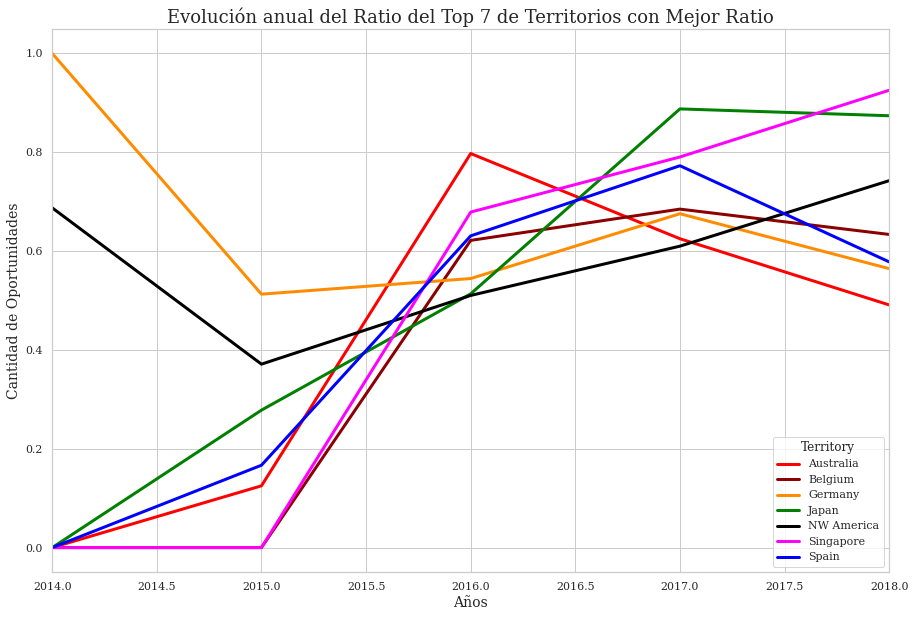

In [785]:
grafico=pd.pivot_table(top7_territorios_year, values='Ratio_Oportunidades_exitosas', index=['Año_Oportunidad']\
               ,columns=['Territory'], aggfunc=np.sum, fill_value=0).plot(figsize=(15,10),\
                color=['red','darkred','darkorange','green','black','magenta','blue'],linewidth=3);
grafico.set_title("Evolución anual del Ratio del Top 7 de Territorios con Mejor Ratio",fontsize=18)
plt.xlim(2014,2018,1)
grafico.set_xlabel("Años",fontsize=14)
grafico.set_ylabel("Cantidad de Oportunidades",fontsize=14);

* (Analizar)

* Analizar grupo de Territorios por tramos de años

* Acá puedo analizar a los territorios en general y luego ver la influecia de los territorios en las regiones en función de casos exitosos y no exitosos. Luego analizar caso Japón

## 5. Estaciones del año

## 6. Toneladas de Refrigeración

In [17]:
### Ahora APAC Pasó de tener un 57,6% de oportunidades exitosas a tener 64,2% de oportunidades exitosas

## Vendedores Responsables de la Oportunidad

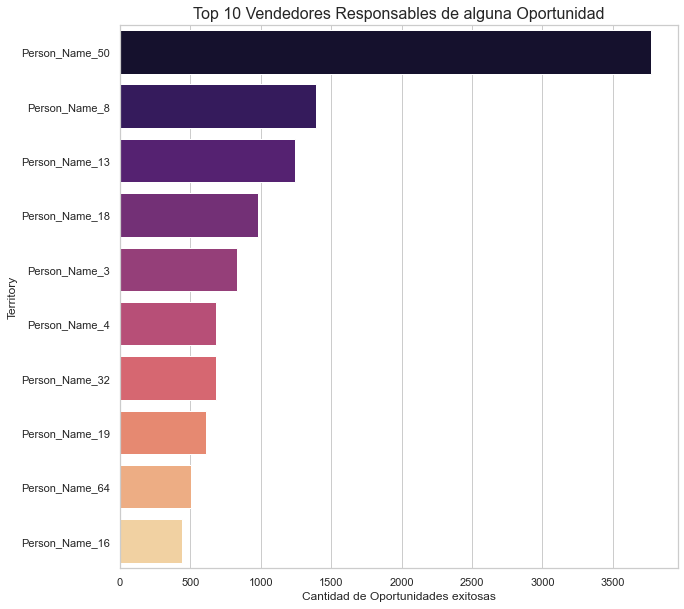

In [22]:
target = df['Opportunity_Owner'].value_counts().head(10)
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=target.values,y=target.index,palette="magma")
grafico_top_key.set_title("Top 10 Vendedores Responsables de alguna Oportunidad",fontsize=16)
grafico_top_key.set_xlabel("Cantidad de Oportunidades exitosas",fontsize=12)
grafico_top_key.set_ylabel("Territory",fontsize=12);

### Datos Temporales